In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('Online-Data.xlsx')

In [6]:
print(data.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  


In [7]:

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d-%m-%Y %H:%M')

# Create a new column for the total price
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [8]:
# Drop any rows with missing values
data = data.dropna()

# Ensure 'Quantity' and 'UnitPrice' are numeric
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data['UnitPrice'] = pd.to_numeric(data['UnitPrice'], errors='coerce')

# Handle any remaining missing values
data = data.dropna()

In [9]:
from datetime import datetime

# Set today's date as the reference point
today = datetime.now()

# Calculate RFM metrics
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (today - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


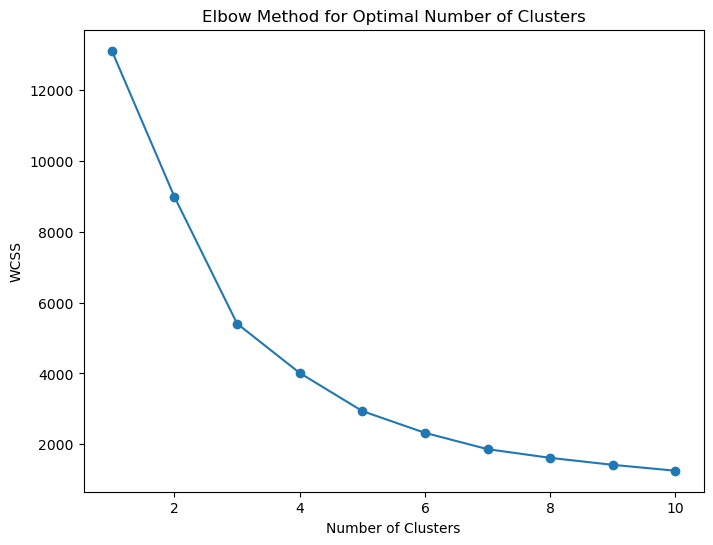

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method result
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Fit KMeans with the optimal number of clusters
optimal_clusters = 4  # Choose based on the Elbow Method result
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


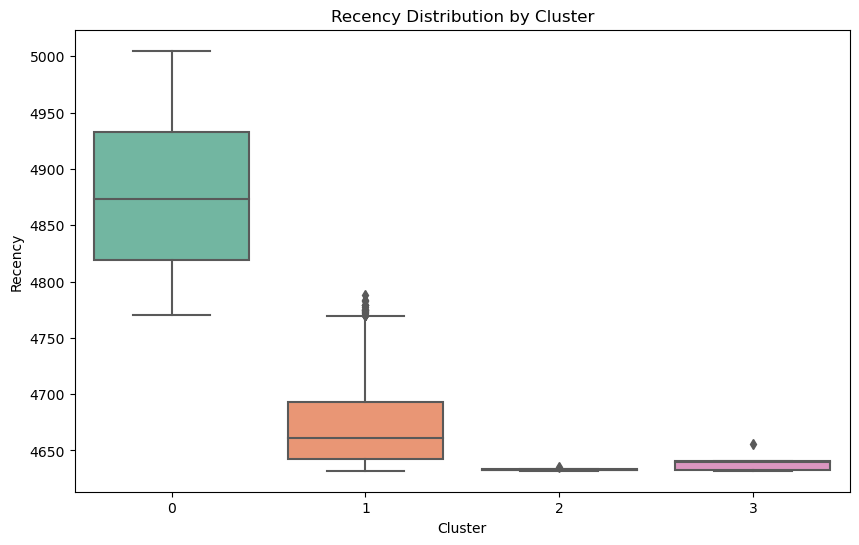

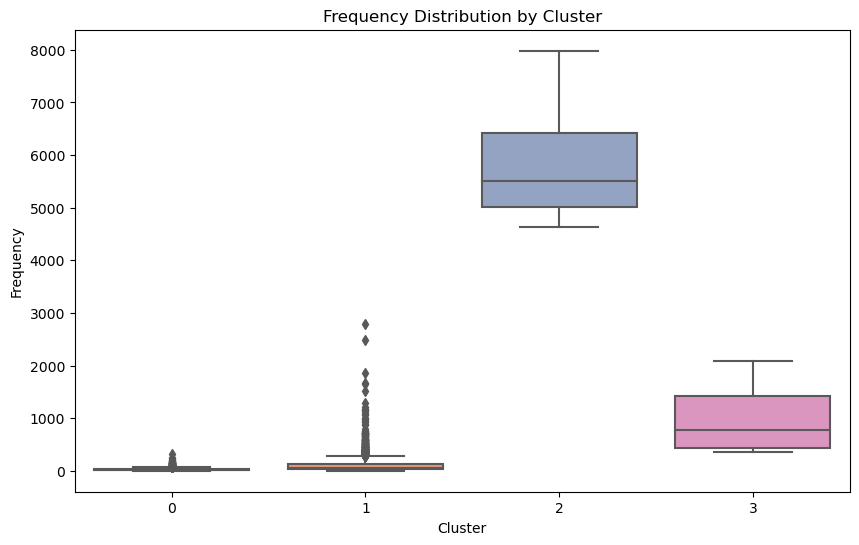

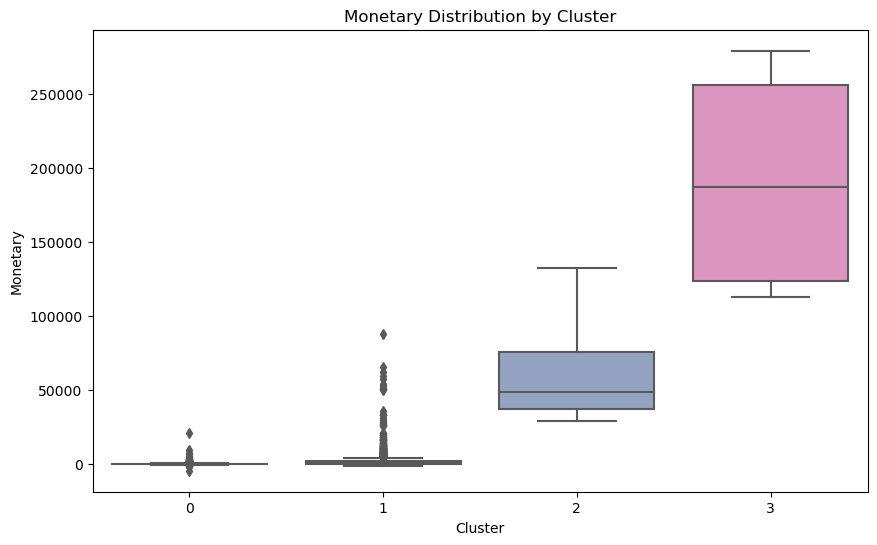

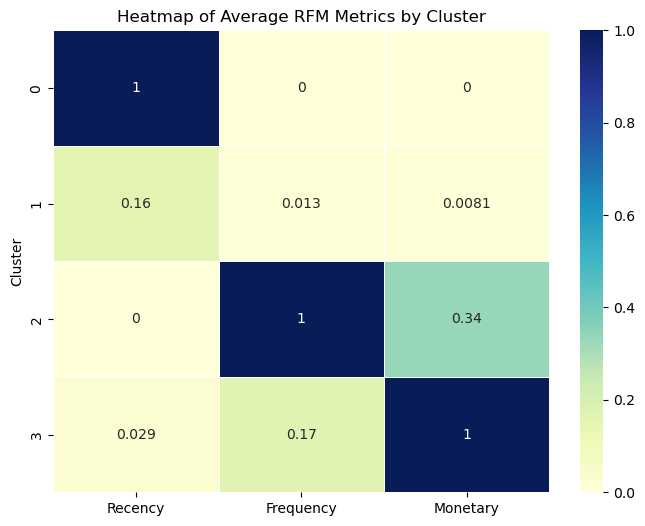

In [11]:
# Boxplot for Recency
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Recency', data=rfm, palette='Set2')
plt.title('Recency Distribution by Cluster')
plt.show()

# Boxplot for Frequency
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Frequency', data=rfm, palette='Set2')
plt.title('Frequency Distribution by Cluster')
plt.show()

# Boxplot for Monetary
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Monetary', data=rfm, palette='Set2')
plt.title('Monetary Distribution by Cluster')
plt.show()

# Heatmap of Cluster Averages
cluster_avg = rfm.groupby('Cluster').mean()[['Recency', 'Frequency', 'Monetary']]
cluster_avg_normalized = cluster_avg.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_avg_normalized, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Average RFM Metrics by Cluster')
plt.show()


In [12]:
# Identify the cluster with the highest average monetary value
high_value_cluster = cluster_avg['Monetary'].idxmax()
high_value_customers = rfm[rfm['Cluster'] == high_value_cluster]

print(f"Number of High-Value Customers: {len(high_value_customers)}")
print("Top 5 High-Value Customers:\n", high_value_customers.sort_values('Monetary', ascending=False).head())


Number of High-Value Customers: 5
Top 5 High-Value Customers:
       CustomerID  Recency  Frequency   Monetary  Cluster
1703     14646.0     4633       2085  279489.02        3
4233     18102.0     4632        433  256438.49        3
3758     17450.0     4640        351  187482.17        3
55       12415.0     4656        778  123725.45        3
1345     14156.0     4641       1420  113384.14        3
